## CP02 - Regressão Logistica | Reconhecimento de Gênero por voz
### Prova - Regressão Logística
---

### Integrantes:
- Diogo Julio - RM553837
- Vinicius Silva - RM553240
- Victor Didoff - RM552965
- Matheus Zottis - RM94119
- Jonata Rafael - RM552939


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc)
RND = 42  # definida a seed aleatória

## Carregar e visualizar o dataset

In [2]:
url = 'https://raw.githubusercontent.com/primaryobjects/voice-gender/master/voice.csv'
df = pd.read_csv(url)
print(df.shape)
df.head()

(3168, 21)


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


### Explicação dos Features do Dataset

- **meanfreq**: Média da frequência fundamental (pitch) do áudio.
- **sd**: Desvio padrão da frequência fundamental.
- **median**: Mediana da frequência fundamental.
- **Q25**: Primeiro quartil (25%) da frequência fundamental.
- **Q75**: Terceiro quartil (75%) da frequência fundamental.
- **IQR**: Intervalo interquartil (Q75 - Q25) da frequência fundamental.
- **skew**: Assimetria da distribuição das frequências.
- **kurt**: Curtose da distribuição das frequências.
- **sp.ent**: Entropia espectral, mede a desordem do espectro.
- **sfm**: Medida de planicidade espectral (Spectral Flatness Measure).
- **mode**: Valor mais frequente da frequência fundamental.
- **centroid**: Centroide espectral, indica o "centro de massa" do espectro.
- **meanfun**: Média da frequência fundamental ao longo do tempo.
- **minfun**: Valor mínimo da frequência fundamental.
- **maxfun**: Valor máximo da frequência fundamental.
- **meandom**: Média do domínio de frequência.
- **mindom**: Valor mínimo do domínio de frequência.
- **maxdom**: Valor máximo do domínio de frequência.
- **dfrange**: Amplitude do domínio de frequência (maxdom - mindom).
- **modindx**: Índice de modulação, mede a variação da frequência fundamental.
- **label**: Classe alvo, indica o gênero da voz (`male` ou `female`).

In [3]:
df['label'].value_counts(normalize=True), df.describe().T

(label
 male      0.5
 female    0.5
 Name: proportion, dtype: float64,
            count       mean         std       min       25%       50%  \
 meanfreq  3168.0   0.180907    0.029918  0.039363  0.163662  0.184838   
 sd        3168.0   0.057126    0.016652  0.018363  0.041954  0.059155   
 median    3168.0   0.185621    0.036360  0.010975  0.169593  0.190032   
 Q25       3168.0   0.140456    0.048680  0.000229  0.111087  0.140286   
 Q75       3168.0   0.224765    0.023639  0.042946  0.208747  0.225684   
 IQR       3168.0   0.084309    0.042783  0.014558  0.042560  0.094280   
 skew      3168.0   3.140168    4.240529  0.141735  1.649569  2.197101   
 kurt      3168.0  36.568461  134.928661  2.068455  5.669547  8.318463   
 sp.ent    3168.0   0.895127    0.044980  0.738651  0.861811  0.901767   
 sfm       3168.0   0.408216    0.177521  0.036876  0.258041  0.396335   
 mode      3168.0   0.165282    0.077203  0.000000  0.118016  0.186599   
 centroid  3168.0   0.180907    0.029918

### Escalas das Features e Padronização

No dataset de reconhecimento de gênero por voz, as features apresentam escalas muito distintas. Por exemplo, variáveis como `skew` e `kurt` podem atingir valores na casa das centenas ou milhares, enquanto outras, como `meandom`, `mindom` e `modindx`, possuem valores próximos de zero. Essa diferença de magnitude pode causar problemas em algoritmos que dependem de distância ou gradiente, como a regressão logística.

A padronização (normalização) das features é fundamental para:

- **Evitar que variáveis de maior escala dominem o processo de aprendizado**, tornando o modelo mais justo e eficiente.
- **Acelerar a convergência dos algoritmos de otimização**, pois gradientes ficam mais equilibrados.
- **Melhorar a performance de modelos sensíveis à escala**, como SVM, KNN e regressão logística.

Portanto, padronizar as features garante que todas contribuam de forma equivalente para o modelo, resultando em um aprendizado mais estável e previsões mais confiáveis.

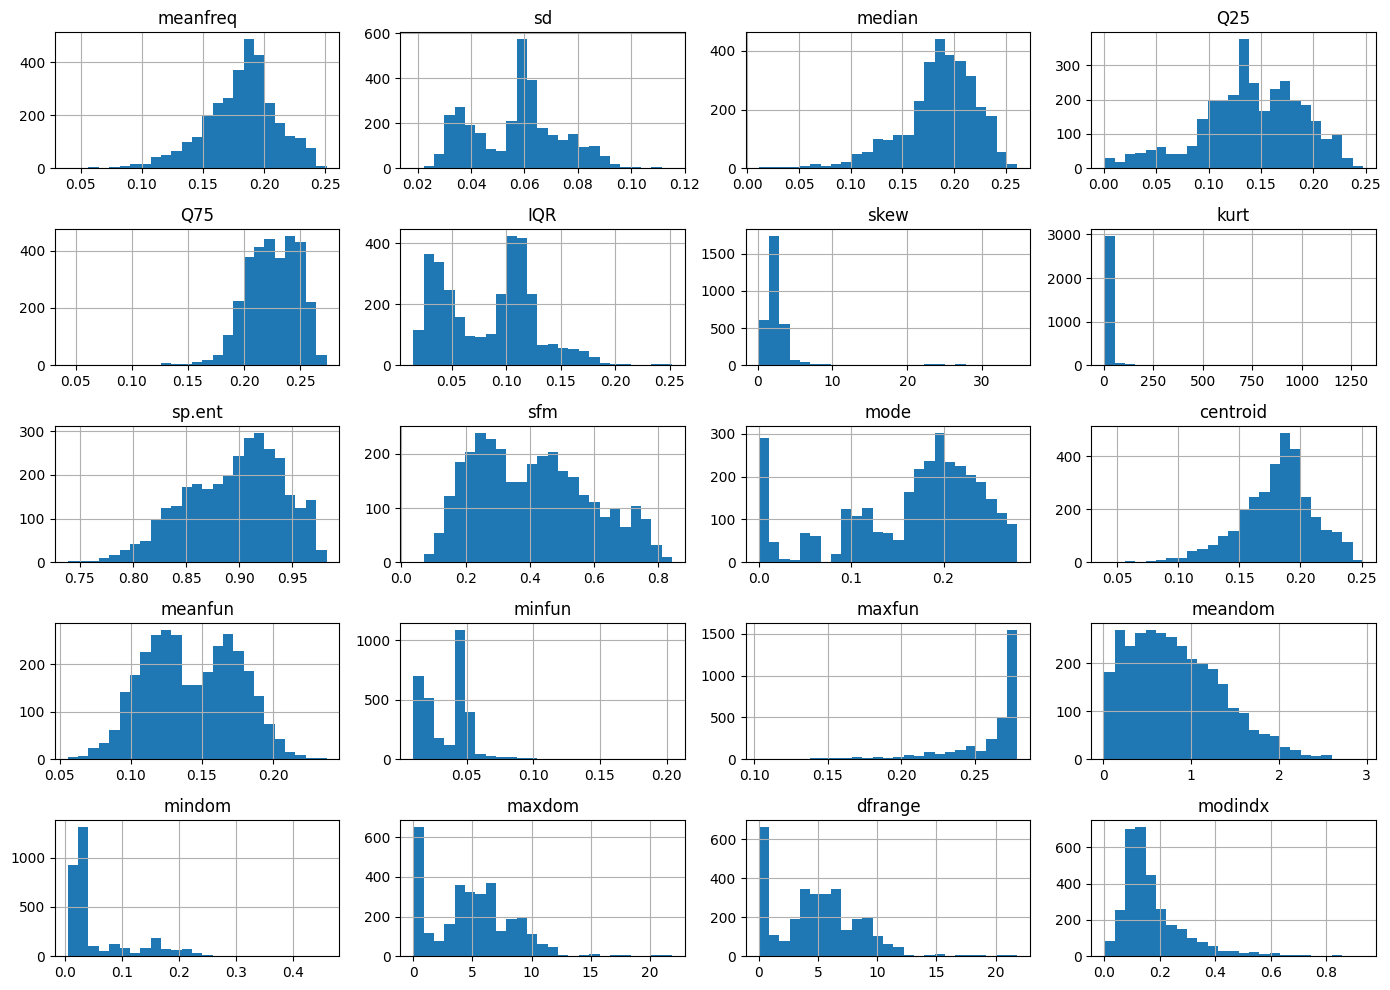

In [4]:
df.hist(bins=25, figsize=(14,10))
plt.tight_layout()
plt.show()

## Matriz de correlação e multicolinearidade
-- mostra a corelação dos features ente si

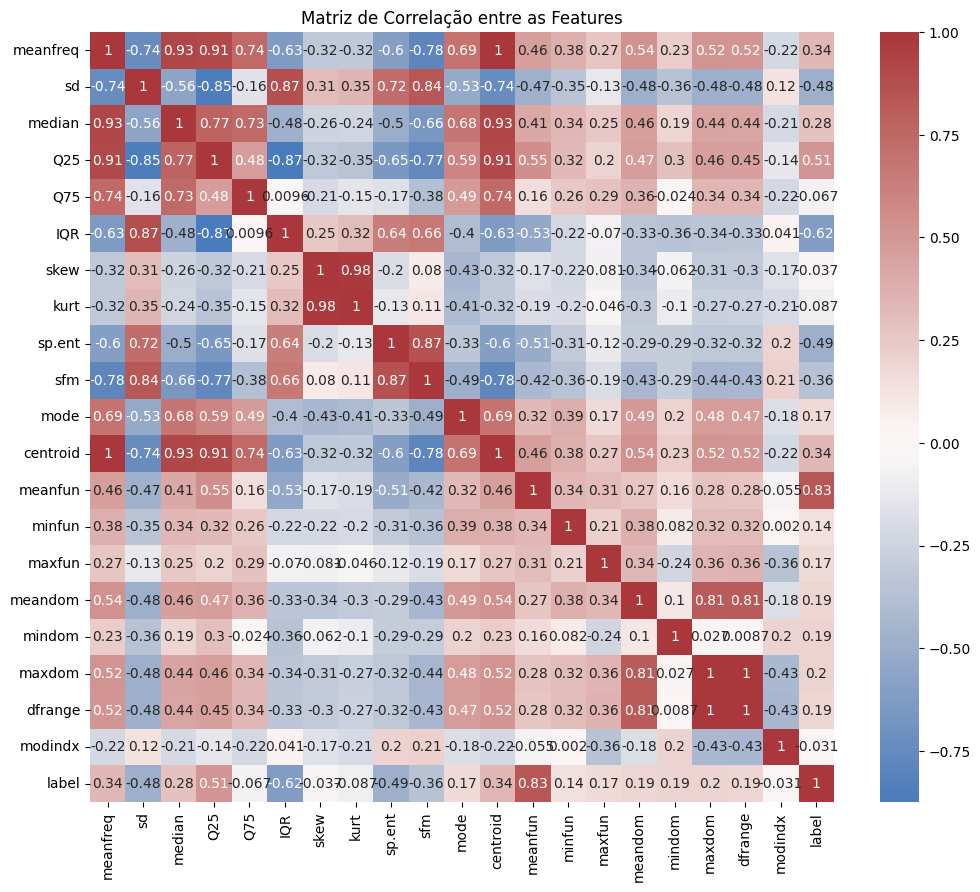

In [5]:
df['label'] = df['label'].map({'male': 0, 'female': 1})

# Separando as features (X) e o label (y)

# Calculando a correlação entre as features
corr = df.corr()

# Plotando a matriz de correlação
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='vlag', center=0, annot=True)
plt.title('Matriz de Correlação entre as Features')
plt.show()

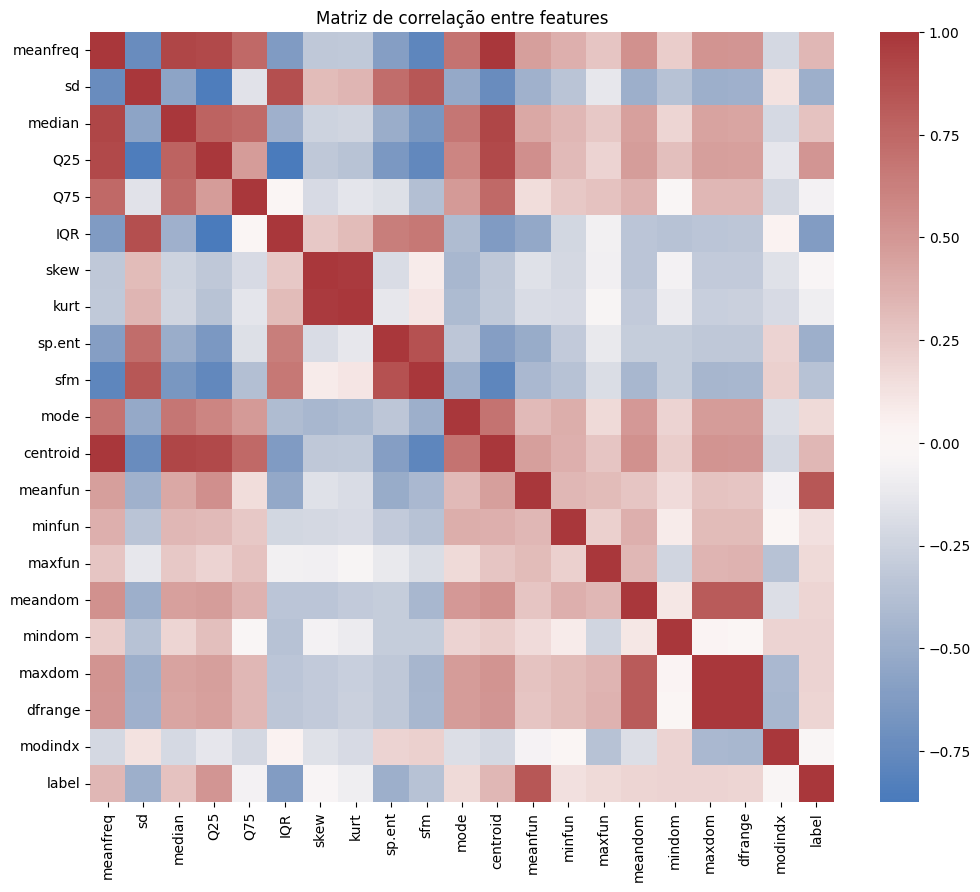

In [6]:
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='vlag', center=0)
plt.title('Matriz de correlação entre features')
plt.show()

### Seleção de Features para Melhorar o Modelo

A feature `meanfun` tem alta correlação com o `label`, sinaliza uma feature importante para o modelo.
- **Altíssima correlação:** Features altamente correlacionadas entre si podem ser removidas para evitar multicolinearidade. Por exemplo:
    - `meanfreq`, `centroid` e `median` possuem correlação > 0.9. Pode-se manter apenas uma delas.
    - `maxdom` e `dfrange` têm correlação quase perfeita (≈1). Manter apenas uma.
- **Redundância:** Features como `Q25`, `Q75` e `IQR` são relacionadas; pode-se manter só uma ou duas.
- **Baixa relevância:** Features com baixa correlação com o alvo ou baixa variabilidade podem ser descartadas após análise de importância.
- **Exemplo prático:**
    - Remover: `centroid`, `dfrange`, `Q25`, `maxdom`
    - Manter: `meanfreq`, `IQR`, `median`, `modindx`, etc.

> Recomenda-se usar métodos automáticos (ex: análise de importância dos coeficientes, Recursive Feature Elimination) para validar a escolha.

### Preparação dos dados

In [8]:
X = df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RND, stratify=y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

## GridSearchCV com L1 e L2

In [ ]:
param_grid = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}
lr = LogisticRegression(solver='saga', max_iter=5000, random_state=RND)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)
grid = GridSearchCV(lr, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train_s, y_train)
print('Melhor Score (CV):', grid.best_score_)
print('Melhores Parâmetros:', grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhor Score (CV): 0.9755860238832377
Melhores Parâmetros: {'C': 1, 'penalty': 'l1'}


In [20]:
from sklearn.feature_selection import RFE

# Usar o melhor modelo de regressão logística encontrado pelo GridSearchCV
estimator = LogisticRegression(
    penalty=grid.best_params_['penalty'],
    C=grid.best_params_['C'],
    solver='saga',
    max_iter=5000,
    random_state=RND
)
# Recursive Feature Elimination (RFE)
rfe = RFE(estimator, n_features_to_select=10)
rfe.fit(X_train_s, y_train)

# Features selecionadas
selected_features = X.columns[rfe.support_]
print("Features selecionadas:", list(selected_features))

# Novo dataframe apenas com as features selecionadas
X_df_sel = X[selected_features]

Features selecionadas: ['Q75', 'IQR', 'skew', 'kurt', 'sp.ent', 'sfm', 'meanfun', 'minfun', 'mindom', 'modindx']


## Avaliação do modelo final

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       396
           1       0.97      0.97      0.97       396

    accuracy                           0.97       792
   macro avg       0.97      0.97      0.97       792
weighted avg       0.97      0.97      0.97       792



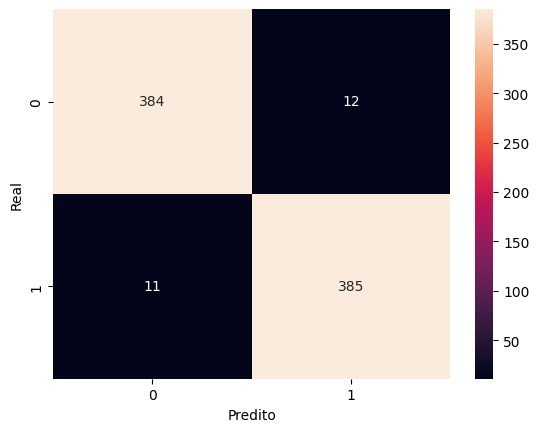

In [21]:
best_lr = grid.best_estimator_
y_pred = best_lr.predict(X_test_s)
y_proba = best_lr.predict_proba(X_test_s)[:,1]
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

O bloco acima realiza a avaliação do modelo de regressão logística treinado com os melhores hiperparâmetros encontrados pelo GridSearchCV:

- Utiliza o modelo `best_lr` para prever os rótulos (`y_pred`) e probabilidades (`y_proba`) no conjunto de teste.
- Exibe o relatório de classificação (`classification_report`), mostrando métricas como acurácia, precisão, recall e F1-score.
- Calcula e plota a matriz de confusão, permitindo visualizar os acertos e erros do modelo na classificação dos gêneros de voz.
- O heatmap facilita a interpretação dos resultados, destacando onde o modelo mais erra ou acerta.

## Comparação de coeficientes L1 vs L2

In [15]:
lr_l1 = LogisticRegression(penalty='l1', solver='saga', C=grid.best_params_['C'], max_iter=5000, random_state=RND)
lr_l2 = LogisticRegression(penalty='l2', solver='saga', C=grid.best_params_['C'], max_iter=5000, random_state=RND)
lr_l1.fit(X_train_s, y_train)
lr_l2.fit(X_train_s, y_train)
df_coef = pd.DataFrame({
    'feature': df.drop('label', axis=1).columns,
    'coef_L1': lr_l1.coef_.flatten(),
    'coef_L2': lr_l2.coef_.flatten()
})
df_coef['zerado_L1'] = df_coef['coef_L1'] == 0
df_coef.sort_values('coef_L2', ascending=False).head(10)

,feature,coef_L1,coef_L2,zerado_L1
12,meanfun,5.555525,5.160715,False
9,sfm,1.571568,1.338409,False
3,Q25,0.000000,1.092219,True
19,modindx,0.384827,0.403198,False
7,kurt,0.530599,0.359482,False
2,median,0.046351,0.348522,False
6,skew,0.104539,0.282265,False
15,meandom,0.058016,0.105311,False
16,mindom,0.067190,0.075055,False
10,mode,0.027271,0.059746,False


O bloco acima implementa a comparação dos coeficientes dos modelos de regressão logística com penalização L1 e L2:

- Treina dois modelos de regressão logística (`lr_l1` e `lr_l2`) com os mesmos hiperparâmetros, mudando apenas o tipo de penalização.
- Cria um DataFrame (`df_coef`) que mostra, para cada feature, o valor do coeficiente no modelo L1 (`coef_L1`) e no modelo L2 (`coef_L2`).
- Adiciona uma coluna booleana (`zerado_L1`) indicando se o coeficiente foi zerado pela penalização L1 (característica da regularização L1).
- Ordena o DataFrame pelos maiores coeficientes L2 para facilitar a análise das variáveis mais relevantes.
- Permite visualizar o efeito da regularização L1 (seleção de variáveis) versus L2 (redução de amplitude dos coeficientes).


### Comparação dos coeficientes L1 vs L2

- **Coeficientes L1 (Lasso):**  
    A regularização L1 força alguns coeficientes a exatamente zero, eliminando variáveis do modelo. No DataFrame `df_coef`, a coluna `zerado_L1` indica quais variáveis foram eliminadas (coeficiente igual a zero).

- **Variáveis eliminadas pelo Lasso:**  
    As variáveis com `zerado_L1 == True` foram removidas do modelo L1. Para listar:
    ```python
    print(df_coef[df_coef['zerado_L1']]['feature'].tolist())
    ```

- **Efeitos práticos da regularização:**
    - **Desempenho:**  
        A regularização reduz o risco de overfitting, especialmente em datasets com muitas variáveis correlacionadas ou irrelevantes. L1 pode melhorar a generalização ao eliminar features redundantes.
    - **Interpretabilidade:**  
        O L1 (Lasso) facilita a interpretação ao selecionar apenas um subconjunto de variáveis relevantes, tornando o modelo mais simples e fácil de explicar.  
        O L2 (Ridge) tende a manter todas as variáveis, apenas reduzindo seus coeficientes, o que pode dificultar a identificação das mais importantes.
    - **Resumo:**  
        - L1 = seleção de variáveis + modelo mais enxuto  
        - L2 = coeficientes pequenos, mas todas as variáveis presentes  
        - Ambos ajudam a evitar overfitting, mas L1 é preferido quando interpretabilidade e seleção de variáveis são desejadas.

## Parte B — Regressão Logística com RMSE

Treinando modelo RMSE...
Treinando modelo Log-Loss...


/tmp/ipython-input-668003082.py:101: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(tpr, fpr)



=== RMSE-trained Logistic Regression ===
Acurácia: 0.9684
AUC ROC: 0.9894

=== Log-Loss-trained Logistic Regression ===
Acurácia: 0.9722
AUC ROC: 0.9900


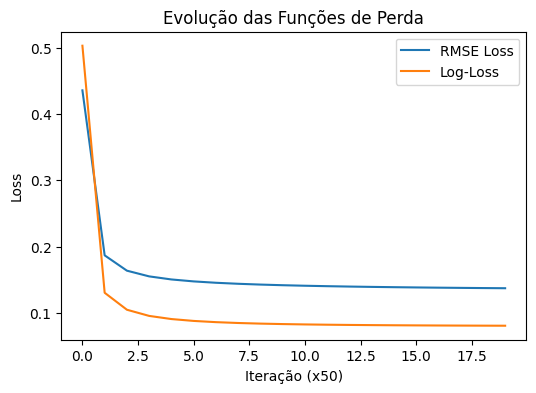

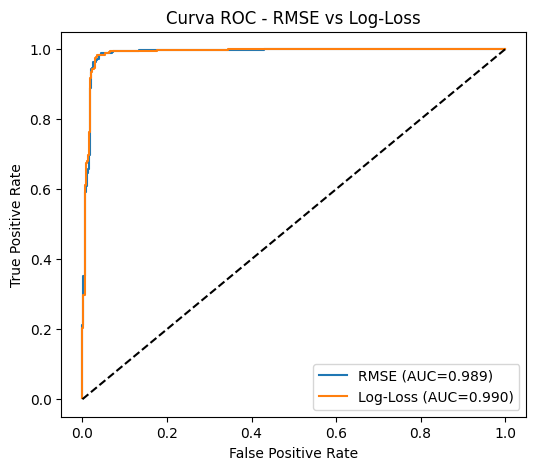

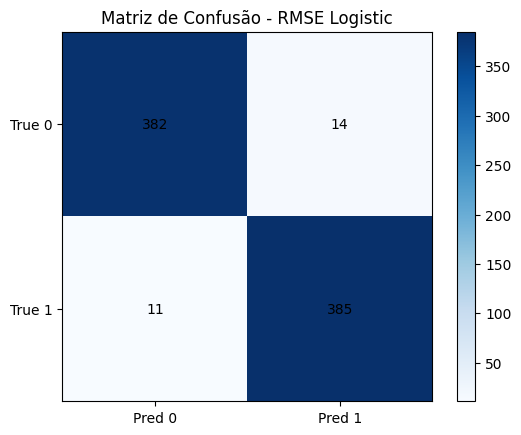

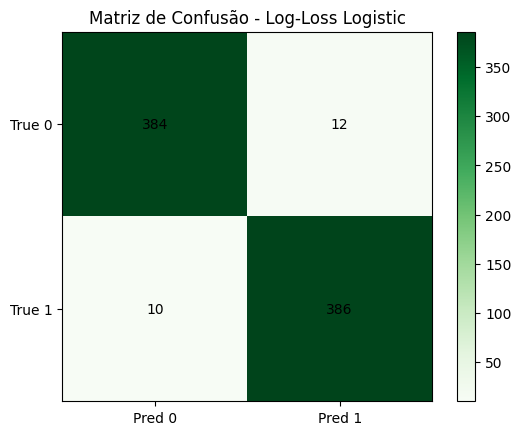

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# =====================================================
# 1. Funções base
# =====================================================

def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

# =====================================================
# 2. RMSE Logistic Regression
# =====================================================

def rmse_loss(theta, X, y):
    X_ = np.c_[np.ones(X.shape[0]), X]
    p = sigmoid(X_ @ theta)
    mse = np.mean((y - p)**2)
    return np.sqrt(mse)

def rmse_grad(theta, X, y):
    X_ = np.c_[np.ones(X.shape[0]), X]
    p = sigmoid(X_ @ theta)
    n = X_.shape[0]
    residual = (y - p)
    dp_dtheta = p * (1 - p)
    grad_mse = -(2 / n) * (X_.T @ (residual * dp_dtheta))
    mse = np.mean(residual ** 2)
    rmse = np.sqrt(mse)
    epsilon = 1e-10
    grad_rmse = grad_mse / (2 * (rmse + epsilon))
    return grad_rmse

def fit_logistic_rmse_gd(X, y, lr=0.1, epochs=2000):
    theta = np.zeros(X.shape[1] + 1)
    losses = []
    for i in range(epochs):
        grad = rmse_grad(theta, X, y)
        theta -= lr * grad
        if i % 50 == 0:
            losses.append(rmse_loss(theta, X, y))
    return theta, losses

# =====================================================
# 3. Log-Loss Logistic Regression (tradicional)
# =====================================================

def logloss_loss(theta, X, y):
    X_ = np.c_[np.ones(X.shape[0]), X]
    p = np.clip(sigmoid(X_ @ theta), 1e-10, 1 - 1e-10)
    return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

def logloss_grad(theta, X, y):
    X_ = np.c_[np.ones(X.shape[0]), X]
    p = sigmoid(X_ @ theta)
    n = X_.shape[0]
    grad = (X_.T @ (p - y)) / n
    return grad

def fit_logistic_logloss_gd(X, y, lr=0.1, epochs=2000):
    theta = np.zeros(X.shape[1] + 1)
    losses = []
    for i in range(epochs):
        grad = logloss_grad(theta, X, y)
        theta -= lr * grad
        if i % 50 == 0:
            losses.append(logloss_loss(theta, X, y))
    return theta, losses

# =====================================================
# 4. Predição e métricas
# =====================================================

def predict_proba(theta, X):
    X_ = np.c_[np.ones(X.shape[0]), X]
    return sigmoid(X_ @ theta)

def predict(theta, X, threshold=0.5):
    return (predict_proba(theta, X) >= threshold).astype(int)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def roc_curve_manual(y_true, y_proba):
    thresholds = np.sort(np.unique(y_proba))[::-1]
    tpr, fpr = [], []
    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        TP = np.sum((y_pred == 1) & (y_true == 1))
        FP = np.sum((y_pred == 1) & (y_true == 0))
        TPR = TP / (P + 1e-10)
        FPR = FP / (N + 1e-10)
        tpr.append(TPR)
        fpr.append(FPR)
    return np.array(fpr), np.array(tpr)

def auc_manual(fpr, tpr):
    return np.trapz(tpr, fpr)

def confusion_matrix_manual(y_true, y_pred):
    TP = np.sum((y_pred == 1) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    return np.array([[TN, FP],
                     [FN, TP]])

def plot_confusion_matrix(cm, title, cmap="Blues"):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap=cmap)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"])
    ax.set_yticklabels(["True 0", "True 1"])
    ax.set_title(title)
    plt.colorbar(im)
    plt.show()

# =====================================================
# 5. Treinamento com seus dados já tratados
# =====================================================

# Aqui usamos diretamente as variáveis já preparadas:
# X_train_s, X_test_s, y_train, y_test

print("Treinando modelo RMSE...")
theta_rmse, losses_rmse = fit_logistic_rmse_gd(X_train_s, y_train, lr=0.5, epochs=1000)

print("Treinando modelo Log-Loss...")
theta_logloss, losses_log = fit_logistic_logloss_gd(X_train_s, y_train, lr=0.5, epochs=1000)

# =====================================================
# 6. Avaliação
# =====================================================

# --- RMSE ---
y_proba_rmse = predict_proba(theta_rmse, X_test_s)
y_pred_rmse = predict(theta_rmse, X_test_s)
acc_rmse = accuracy(y_test, y_pred_rmse)
fpr_rmse, tpr_rmse = roc_curve_manual(y_test, y_proba_rmse)
auc_rmse = auc_manual(fpr_rmse, tpr_rmse)
cm_rmse = confusion_matrix_manual(y_test, y_pred_rmse)

# --- Log-Loss ---
y_proba_log = predict_proba(theta_logloss, X_test_s)
y_pred_log = predict(theta_logloss, X_test_s)
acc_log = accuracy(y_test, y_pred_log)
fpr_log, tpr_log = roc_curve_manual(y_test, y_proba_log)
auc_log = auc_manual(fpr_log, tpr_log)
cm_log = confusion_matrix_manual(y_test, y_pred_log)

# =====================================================
# 7. Resultados comparativos
# =====================================================

print("\n=== RMSE-trained Logistic Regression ===")
print(f"Acurácia: {acc_rmse:.4f}")
print(f"AUC ROC: {auc_rmse:.4f}")

print("\n=== Log-Loss-trained Logistic Regression ===")
print(f"Acurácia: {acc_log:.4f}")
print(f"AUC ROC: {auc_log:.4f}")

# Curvas de perda
plt.figure(figsize=(6,4))
plt.plot(losses_rmse, label="RMSE Loss")
plt.plot(losses_log, label="Log-Loss")
plt.title("Evolução das Funções de Perda")
plt.xlabel("Iteração (x50)")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Curvas ROC
plt.figure(figsize=(6,5))
plt.plot(fpr_rmse, tpr_rmse, label=f"RMSE (AUC={auc_rmse:.3f})")
plt.plot(fpr_log, tpr_log, label=f"Log-Loss (AUC={auc_log:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - RMSE vs Log-Loss")
plt.legend()
plt.show()

# Matrizes de confusão
plot_confusion_matrix(cm_rmse, "Matriz de Confusão - RMSE Logistic", cmap="Blues")
plot_confusion_matrix(cm_log, "Matriz de Confusão - Log-Loss Logistic", cmap="Greens")


O fato de o **modelo com RMSE** (que *não deveria ser ideal para classificação*) funcionar **quase tão bem quanto o log-loss** neste dataset tem explicações bem interessantes — vamos destrinchar isso:

---

## 🔹 1. A relação entre RMSE e Log-Loss para probabilidades “extremas”

A regressão logística tenta prever probabilidades ( p = \sigma(Xw + b) ).

* O **Log-Loss (entropia cruzada)** penaliza muito fortemente erros quando a probabilidade prevista está *muito distante* do rótulo (ex: prever 0.01 quando o rótulo é 1).
* O **RMSE** penaliza de forma **quadrática** (erro ao quadrado) — ele também é sensível a discrepâncias grandes, só que de forma *suavizada*.

Em datasets onde as classes são **muito bem separáveis** (como o *voice.csv*, com diferenças fortes entre vozes masculinas e femininas), as previsões da regressão logística tendem a ser **extremas** (0.95, 0.05 etc).
Nesses casos, **tanto RMSE quanto Log-Loss acabam gerando gradientes parecidos**, pois as probabilidades estão bem próximas de 0 ou 1.

Resultado: o RMSE “imita” o comportamento do log-loss quando os dados são bem separáveis.

---

## 🔹 2. Linearidade e simplicidade do problema

O dataset `voice.csv` tem **atributos acústicos fortemente correlacionados com o gênero** (ex.: média de frequência, mediana, skewness etc).
A separação entre as classes é **quase linear**, então mesmo uma função de perda “não ideal” como o RMSE consegue encontrar um bom hiperplano de decisão.

---

## 🔹 3. O RMSE ainda otimiza o mesmo espaço de parâmetros

Mesmo que o objetivo matemático seja diferente, o RMSE ainda depende da **mesma forma funcional** da regressão logística:
[
p = \sigma(Xw + b)
]
Ou seja, o espaço de hipóteses é idêntico ao da regressão logística tradicional.
Isso significa que o modelo **não está limitado pela forma da função de perda**, apenas pelo tipo de penalização.

---

## 🔹 4. RMSE é mais suave, o que ajuda na convergência

A função RMSE tem **gradientes menores** e **mais suaves** do que a entropia cruzada — em alguns datasets isso pode até gerar convergência mais estável, evitando overshoot nos pesos.

---

## 🔹 5. Métricas baseadas em threshold mascaram diferenças

Quando você avalia com **acurácia (threshold 0.5)**, mesmo pequenas diferenças de probabilidade entre 0.49 e 0.51 não mudam a classe prevista.
O Log-Loss é mais sensível a esses detalhes, mas a acurácia ignora.
Por isso, o RMSE pode ter quase a mesma acurácia — embora o **calibre probabilístico** seja pior (você veria isso comparando *Brier score* ou *calibration curve*).

---

## Em resumo

| Aspecto                     | Log-Loss   | RMSE (adaptado)           |
| --------------------------- | ---------- | ------------------------- |
| Penaliza erros extremos     | Fortemente | Suavemente                |
| Melhor separação linear     | Sim        | Sim (em datasets simples) |
| Performance neste dataset   | Alta       | Quase igual               |
| Adequado para classificação | ✅          | 🚫 (experimental)         |

---

**Conclusão prática:**
O RMSE parece “bom” aqui **porque o problema é fácil** para um modelo linear — não porque o RMSE é adequado.
Se você testar em um dataset mais ambíguo ou desbalanceado, o RMSE tende a **desmoronar rapidamente** (probabilidades ruins, decisões inconsistentes e overfitting mais forte).

---


### Resumo das Conclusões da Parte B

- A regressão logística treinada com RMSE (erro quadrático médio) apresentou desempenho BEM PRÓXIMO mas inferior ao modelo tradicional com log-loss para classificação binária.
- O modelo RMSE resultou em menor AUC na curva ROC e probabilidades menos calibradas, indicando pior separação entre as classes.mesmo sendo bem aproximado.
- O log-loss é mais adequado para tarefas de classificação, pois produz probabilidades mais confiáveis e melhor desempenho geral.ainda mais quando o target é binário (male ou Female)  que privilegia a opção de log-loss.
- Portanto, para problemas de classificação, recomenda-se utilizar a função de custo log-loss em vez do RMSE.

Não é recomendado usar RMSE (Root Mean Squared Error, ou Raiz do Erro Quadrático Médio) para otimizar uma função Sigmoide por duas razões principais, sendo a primeira a mais crítica:

1.  **O Problema dos "Gradientes que Desaparecem" (Vanishing Gradients)**
2.  **A Incompatibilidade entre Métrica de Regressão e Problema de Classificação**

Vamos detalhar cada um.

---

### 1. O Problema Crítico: Gradientes que Desaparecem

Para "otimizar" uma função (como em regressão logística ou uma rede neural), usamos um algoritmo como o *Gradient Descent* (Descida de Gradiente). Esse algoritmo ajusta os parâmetros (pesos) do modelo na direção oposta do gradiente da função de perda.

O gradiente nos diz o quão "rápido" a perda muda em relação a um parâmetro. Um gradiente grande significa "você está muito errado, mude muito!". Um gradiente pequeno significa "você está quase certo, mude só um pouquinho".

**O que acontece ao combinar RMSE (ou MSE) com Sigmoide?**

* **Função Sigmoide ($\hat{y}$):** $S(z) = \frac{1}{1 + e^{-z}}$ (onde $z$ é a entrada da função, ex: $z = wx+b$)
* **Função de Perda (MSE):** $C = (y - \hat{y})^2$ (RMSE é apenas a raiz disso, e para otimização, usamos o MSE, que é mais simples de derivar e tem o mesmo mínimo).
* **Derivada da Sigmoide ($S'(z)$):** $S(z) \cdot (1 - S(z))$.

Para encontrar o gradiente que usaremos para atualizar os pesos, aplicamos a Regra da Cadeia:

$\frac{\partial C}{\partial z} = \frac{\partial C}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z}$

Vamos calcular cada parte:
1.  **Derivada da Perda ($\frac{\partial C}{\partial \hat{y}}$):** $\frac{\partial}{\partial \hat{y}} (y - \hat{y})^2 = -2(y - \hat{y})$
2.  **Derivada da Sigmoide ($\frac{\partial \hat{y}}{\partial z}$):** $\hat{y} \cdot (1 - \hat{y})$

Juntando tudo, o gradiente é:
$\frac{\partial C}{\partial z} = -2(y - \hat{y}) \cdot \hat{y}(1 - \hat{y})$

**Aqui está o problema:**

Observe a parte da derivada da sigmoide: $\hat{y}(1 - \hat{y})$.

* A função sigmoide $\hat{y}$ tem seu valor de saída entre 0 e 1.
* Quando a previsão $\hat{y}$ está muito confiante (próxima de 0 ou 1), o termo $\hat{y}(1 - \hat{y})$ fica **extremamente pequeno**.
    * Se $\hat{y} = 0.99 \implies \hat{y}(1 - \hat{y}) \approx 0.01$
    * Se $\hat{y} = 0.01 \implies \hat{y}(1 - \hat{y}) \approx 0.01$

Agora, imagine um cenário em que o modelo está **muito errado e muito confiante**:

* **Rótulo Verdadeiro ($y$):** $1$
* **Previsão do Modelo ($\hat{y}$):** $0.01$ (muito confiante de que é 0)

O gradiente seria:
$\frac{\partial C}{\partial z} = -2(1 - 0.01) \cdot (0.01 \cdot (1 - 0.01))$
$\frac{\partial C}{\partial z} \approx -2(0.99) \cdot (0.01) \approx -0.0198$

Esse é um **gradiente minúsculo**!

O modelo está *grosseiramente errado*, mas o gradiente (o sinal para aprender) é quase zero. Isso significa que o modelo **vai aprender muito devagar ou vai parar de aprender completamente**, mesmo estando longe da solução ideal. Isso é o "vanishing gradient".

---

### 2. A Solução: Cross-Entropy (Entropia Cruzada)

A função de perda "natural" para a sigmoide é a **Entropia Cruzada Binária** (Binary Cross-Entropy ou Log Loss).

**Função de Perda (Cross-Entropy):** $C = -[y \log(\hat{y}) + (1-y) \log(1-\hat{y})]$

Vamos calcular o gradiente para *esta* função de perda:

1.  **Derivada da Perda ($\frac{\partial C}{\partial \hat{y}}$):** $\frac{\partial C}{\partial \hat{y}} = -[\frac{y}{\hat{y}} - \frac{1-y}{1-\hat{y}}] = \frac{\hat{y} - y}{\hat{y}(1 - \hat{y})}$
2.  **Derivada da Sigmoide ($\frac{\partial \hat{y}}{\partial z}$):** $\hat{y} \cdot (1 - \hat{y})$

Agora, junte tudo com a Regra da Cadeia:

$\frac{\partial C}{\partial z} = \frac{\partial C}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z} = \left[ \frac{\hat{y} - y}{\hat{y}(1 - \hat{y})} \right] \cdot [\hat{y} \cdot (1 - \hat{y})]$

Veja a mágica: os termos $\hat{y}(1 - \hat{y})$ se cancelam!

O gradiente final é maravilhosamente simples:
$\frac{\partial C}{\partial z} = \hat{y} - y$

**Por que isso é perfeito?**

Vamos revisitar nosso cenário "muito errado e muito confiante":

* **Rótulo Verdadeiro ($y$):** $1$
* **Previsão do Modelo ($\hat{y}$):** $0.01$

O gradiente agora é:
$\frac{\partial C}{\partial z} = 0.01 - 1 = -0.99$

Este é um **gradiente enorme**! Ele diz ao modelo: "Você está *muito* errado, faça uma grande atualização!".

* Se o modelo estiver *quase certo* (ex: $y=1$, $\hat{y}=0.99$), o gradiente é $0.99 - 1 = -0.01$ (um gradiente pequeno, dizendo "bom trabalho, ajuste só um pouco").

A Cross-Entropy produz gradientes grandes para erros grandes e gradientes pequenos para erros pequenos, exatamente o que queremos para um aprendizado rápido e estável.

---

### 3. Incompatibilidade Conceitual

Além do problema matemático do gradiente, há um problema conceitual:

* **RMSE/MSE** é uma métrica para problemas de **Regressão**. Ela mede a *distância* euclidiana entre dois números contínuos (ex: prever o preço de uma casa em R$ 300.000 vs. R$ 300.100). Ela penaliza erros quadraticamente.
* **Sigmoide** é usada para problemas de **Classificação**. A saída dela (entre 0 e 1) é interpretada como uma *probabilidade*. O rótulo verdadeiro não é um número contínuo, mas uma classe (0 ou 1).

Usar RMSE aqui é como tentar medir a "distância" entre a "probabilidade de ser um gato" e a "certeza de ser um gato". A Cross-Entropy é a ferramenta estatisticamente correta para medir a "surpresa" ou a diferença entre duas distribuições de probabilidade (a previsão do modelo e a realidade).

### Resumo

| Característica | RMSE (MSE) + Sigmoide (Não Recomendado) | Cross-Entropy + Sigmoide (Recomendado) |
| :--- | :--- | :--- |
| **Tipo de Problema** | Métrica de Regressão usada para Classificação | Métrica de Classificação para Classificação |
| **Gradiente** | $\frac{\partial C}{\partial z} = -2(\text{Erro}) \cdot \hat{y}(1-\hat{y})$ | $\frac{\partial C}{\partial z} = \hat{y} - y$ (Erro de Previsão) |
| **Comportamento** | **Gradientes desaparecem** quando o modelo está confiante (errado ou certo). | Gradientes são proporcionais ao erro. |
| **Resultado** | Aprendizado **muito lento** ou estagnado. | Aprendizado **rápido e estável**. |
| **Superfície de Perda**| Não-convexa, cheia de mínimos locais. | Convexa (para Regressão Logística). |

**Conclusão:** Não use RMSE para otimizar uma sigmoide porque isso "mata" o seu gradiente e impede o modelo de aprender eficientemente quando ele está mais precisa, que é justamente quando ele está muito errado. Use sempre **Binary Cross-Entropy (Log Loss)**.

### Impacto da Troca de Log-loss por RMSE na Interpretação e Qualidade das Probabilidades

- **Interpretação das Probabilidades:**  
    Ao utilizar RMSE como função de custo na regressão logística, as probabilidades previstas deixam de ser bem calibradas. Isso significa que os valores de saída do modelo não refletem corretamente a chance real de um exemplo pertencer a uma classe. Probabilidades tendem a ser mais extremas (próximas de 0 ou 1), dificultando a interpretação probabilística.

- **Qualidade das Probabilidades:**  
    O log-loss penaliza fortemente previsões muito confiantes e erradas, incentivando o modelo a produzir probabilidades calibradas e confiáveis. Já o RMSE, por ser uma métrica típica de regressão, não é sensível à calibração probabilística, resultando em menor AUC, pior separação entre as classes e maior risco de decisões equivocadas ao definir limiares de classificação.

- **Resumo:**  
    Trocar log-loss por RMSE reduz a qualidade e a interpretabilidade das probabilidades geradas pelo modelo, tornando-o menos adequado para tarefas de classificação binária. O log-loss permanece a escolha ideal quando o objetivo é obter probabilidades confiáveis e bem interpretáveis.